In [ ]:
# Model List

# model1
l1= 60 # state
l2 = 4 # action

model = torch.nn.Sequential(
    torch.nn.Linear(l1,l2,bias=False)
)

In [1]:
import numpy as np
import gym
import random
from lava_grid import ZigZag6x10
from tqdm.notebook import tqdm
import math
import matplotlib
import matplotlib.pyplot as plt
import torch
from collections import Counter
import torch.nn.functional as F
from sklearn import metrics
import pandas as pd

In [4]:
# ignore warnings (for df.append)
import warnings
warnings.filterwarnings("ignore")

save_dir = 'figures'


# initialize dataframe
hyperparams = ['model', 'gamma', 'learning rate', '1st noise', '2nd noise', 'max reward', 'max reached', 'AUC']

result = pd.DataFrame(columns=hyperparams)

In [3]:
# parameters for grid search

# all candidates
# gamma_list = [0.90, 0.95, 0.98]
# lr_list = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05]
# first_noise_list = [None, 1.0, 4.0, 7.0, 10.0]
# second_noise_list = [None, 1.0, 4.0, 7.0, 10.0]

# first trial
gamma_list = [0.90, 0.95]
lr_list = [0.001, 0.005, 0.01]
first_noise_list = [None, 1.0, 5.0, 10.0]
second_noise_list = [None, 1.0, 5.0, 10.0]

total = len(gamma_list) * len(lr_list) * len(first_noise_list) * len(second_noise_list)
print(f'total number of cases: {total}')

total number of cases: 96


In [18]:
def run_lava(df, model_name, gamma, learning_rate, first_noise, second_noise, save_plot=True):

    # default setting
    max_steps = 100
    stochasticity = 0 # probability of the selected action failing and instead executing any of the remaining 3
    no_render = True

    env = ZigZag6x10(max_steps=max_steps, act_fail_prob=stochasticity, goal=(5, 9), numpy_state=False)
    rrecord = []

    l1= 60 # state
    l2 = 4 # action

    model = torch.nn.Sequential(
        torch.nn.Linear(l1,l2,bias=False)
    )

    normal_reward = -0.01

    loss_fn = torch.nn.MSELoss()
    optimizer  = torch.optim.Adam(model.parameters(),lr = learning_rate)

    epochs = 3000
    losses = [] 

    for epoch in range(epochs): 
        s = env.reset()
        done = False
        cum_reward = 0.0

        state_ = np.eye(env.nS)[s] # 벡터로
        state1 = torch.from_numpy(state_).float()

        status = 1 

        i = 0
        nn = True

        while(status == 1 and i <= max_steps):
            i += 1

            qval = model(state1)
            qval_ = qval.data.numpy()
            if first_noise != None:
                qval_ += np.random.rand(4) * first_noise/(epoch+1) # add random noise to actions

            action_ = np.argmax(qval_)

            ns, reward, done, _ = env.step(action_)
            cum_reward += reward

            state2_ = ns
            state2 = torch.from_numpy(state2_).float() 

            with torch.no_grad():
                newQ = model(state2)
                if second_noise != None:
                    newQ += torch.randn(4) * second_noise/(epoch+1) # add random noise to actions

            maxQ = torch.max(newQ) 
            if reward == normal_reward: 
                Y = reward + (gamma * maxQ)
            else:
                Y = reward

            Y = torch.Tensor([Y]).detach()
            X = qval.squeeze()[action_].reshape([1])
            loss = loss_fn(X, Y) 
            # loss = F.smooth_l1_loss(X, Y)

           #clear_output(wait=True)

            optimizer.zero_grad()
            loss.backward()
            losses.append(loss.item())
            optimizer.step()

            state1 = state2

            if reward != normal_reward: 
                status = 0

        rrecord.append(cum_reward)

    # save reward graph
    x = [i+1 for i in range(len(rrecord))]
    plt.plot(x, rrecord)
    plt.title('Episode Rewards')
    plt.xlabel('Episodes')
    plt.ylabel('Rewards')
    if save_plot == True:
        plt.savefig(f'{save_dir}/reward_{model_name}_{gamma}_{learning_rate}_{first_noise}_{second_noise}.png')
    else:
        plt.show()
    plt.close()

    # save loss graph
    plt.plot(losses)
    plt.title('Loss')
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    if save_plot == True:
        plt.savefig(f'{save_dir}/loss_{model_name}_{gamma}_{learning_rate}_{first_noise}_{second_noise}.png')
    else:
        plt.show()
    plt.close()

    # add record to dataframe
    max_reward = max(rrecord)

    max_reached = -1
    for idx, reward in enumerate(rrecord):
        if reward == max_reward:
            max_reached = idx + 1
            break

    auc = round(metrics.auc(x, rrecord), 2)

    row = [model_name, gamma, learning_rate, first_noise, second_noise, max_reward, max_reached, auc]
    df = df.append(pd.Series(row, index = df.columns), ignore_index=True)
    
    return df, auc

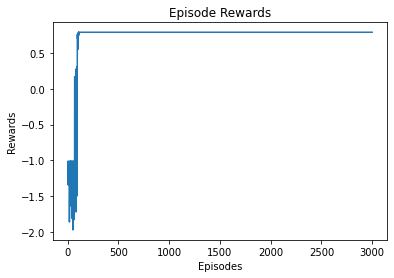

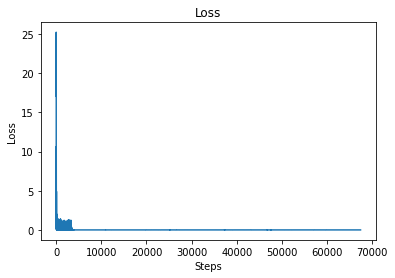

CPU times: user 40.6 s, sys: 44 ms, total: 40.6 s
Wall time: 40.6 s


,model,gamma,learning rate,1st noise,2nd noise,max reward,max reached,AUC
0,model1,0.9,0.01,10.0,5.0,0.81,98,2229.83
1,model1,0.9,0.005,5.0,None,0.79,105,2180.12


In [26]:
%%time
# test for specific parameter

gamma = 0.90
learning_rate = 0.005
first_noise = 5.0
second_noise = None

result, _ = run_lava(result, 'model1', gamma, learning_rate, first_noise, second_noise, save_plot=False)
result

In [5]:
%%time
# run grid search

total = len(gamma_list) * len(lr_list) * len(first_noise_list) * len(second_noise_list)
done = 0

# model name
model_name = 'model1'

for gamma in gamma_list:
    for learning_rate in lr_list:
        for first_noise in first_noise_list:
            for second_noise in second_noise_list:
                result, auc = run_lava(result, model_name, gamma, learning_rate, first_noise, second_noise)
                done += 1
                print(f'[{done}/{total} done] AUC of {model_name}_{gamma}_{learning_rate}_{first_noise}_{second_noise} : {auc}')

[1/96 done] AUC of model1_0.9_0.001_None_None : -3063.42
[2/96 done] AUC of model1_0.9_0.001_None_1.0 : -3044.42
[3/96 done] AUC of model1_0.9_0.001_None_5.0 : 1044.77
[4/96 done] AUC of model1_0.9_0.001_None_10.0 : -1952.8
[5/96 done] AUC of model1_0.9_0.001_1.0_None : 2156.93
[6/96 done] AUC of model1_0.9_0.001_1.0_1.0 : 2118.04
[7/96 done] AUC of model1_0.9_0.001_1.0_5.0 : -3050.98
[8/96 done] AUC of model1_0.9_0.001_1.0_10.0 : -3045.32
[9/96 done] AUC of model1_0.9_0.001_5.0_None : 1833.58
[10/96 done] AUC of model1_0.9_0.001_5.0_1.0 : 1921.59
[11/96 done] AUC of model1_0.9_0.001_5.0_5.0 : 1847.48
[12/96 done] AUC of model1_0.9_0.001_5.0_10.0 : -3059.08
[13/96 done] AUC of model1_0.9_0.001_10.0_None : 1836.51
[14/96 done] AUC of model1_0.9_0.001_10.0_1.0 : 1812.27
[15/96 done] AUC of model1_0.9_0.001_10.0_5.0 : 1873.73
[16/96 done] AUC of model1_0.9_0.001_10.0_10.0 : 1586.27
[17/96 done] AUC of model1_0.9_0.005_None_None : -3035.86
[18/96 done] AUC of model1_0.9_0.005_None_1.0 : 19

In [6]:
# check result
result['max reached'] = result['max reached'].astype(int)
result

,model,gamma,learning rate,1st noise,2nd noise,max reward,max reached,AUC
0,model1,0.9,0.001,None,None,-1.01,108,-3063.42
1,model1,0.9,0.001,None,1.0,-1.01,1,-3044.42
2,model1,0.9,0.001,None,5.0,0.77,653,1044.77
3,model1,0.9,0.001,None,10.0,0.77,2381,-1952.8
4,model1,0.9,0.001,1.0,None,0.81,142,2156.93
...,...,...,...,...,...,...,...,...
91,model1,0.95,0.01,5.0,10.0,-1.01,8,-3042.34
92,model1,0.95,0.01,10.0,None,0.79,130,2119.97
93,model1,0.95,0.01,10.0,1.0,0.77,135,2054.97
94,model1,0.95,0.01,10.0,5.0,0.81,104,2227.78


In [8]:
# sort by AUC values
result.sort_values(by='AUC', ascending=False).head(20)
# result.sort_values(by='max reward', ascending=False)

,model,gamma,learning rate,1st noise,2nd noise,max reward,max reached,AUC
85,model1,0.95,0.010,1.0,1.0,0.81,50,2287.04
24,model1,0.90,0.005,5.0,NaN,0.81,98,2241.83
46,model1,0.90,0.010,10.0,5.0,0.81,111,2237.35
36,model1,0.90,0.010,1.0,NaN,0.77,45,2231.35
88,model1,0.95,0.010,5.0,NaN,0.79,74,2229.07
94,model1,0.95,0.010,10.0,5.0,0.81,104,2227.78
41,model1,0.90,0.010,5.0,1.0,0.79,82,2219.52
84,model1,0.95,0.010,1.0,NaN,0.77,63,2185.13
78,model1,0.95,0.005,10.0,5.0,0.81,140,2183.21
73,model1,0.95,0.005,5.0,1.0,0.81,132,2177.64


In [7]:
# save dataframe as csv
result.to_csv(f'result/result_220614.csv', index=None) # date: subject to change

In [9]:
# load dataframe from csv
# result = pd.read_csv(f'result/result_220614.csv')